In [1]:
# pip install openinference-instrumentation-dspy dspy
# pip install openinference-instrumentation-litellm arize-phoenix litellm

In [2]:
import pandas as pd
import gc
import torch
from datasets import Dataset
from tqdm.notebook import tqdm
import random
from dspy.datasets import DataLoader
random.seed(42)
dl = DataLoader()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from dspy.teleprompt import BootstrapFewShot
from dspy.teleprompt import MIPROv2
import phoenix as px
phoenix_session = px.launch_app()
print(phoenix_session.url)
from openinference.instrumentation.dspy import DSPyInstrumentor
from openinference.instrumentation.litellm import LiteLLMInstrumentor
from phoenix.otel import register

tracer_provider = register(project_name='LLMs')

file_path = 'cleaned_concatenated.csv'
df = pd.read_csv(file_path)
df.head()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
http://localhost:6006/
🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: LLMs
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



,index,Question,Recommendation
0,0,How does one determine the optimal DMARC polic...,Determining the optimal DMARC policy for a dom...
1,1,How does the err tag in a DMARC record handle ...,In the context of email authentication protoco...
2,2,How does the presence or absence of the l tag ...,The l tag in a DMARC record plays a crucial ro...
3,3,How does the rua tag in a DMARC record enable ...,The rua tag in a DMARC record plays a crucial ...
4,4,"Can the mode tag in a DMARC record be omitted,...","In the context of DKIM, DMARC, and SPF, the mo..."


In [3]:
import langwatch
langwatch.api_key = 'YOUR API KEY'

In [4]:
# https://dspy.ai/learn/optimization/overview/    # 20% train, 80% test
trainset_df, devset_df = train_test_split(df, test_size=0.1, random_state=42)  

trainset_df = Dataset.from_pandas(trainset_df)
devset_df = Dataset.from_pandas(devset_df)

In [5]:
trainset_df.shape

(145, 4)

In [6]:
devset_df.shape

(17, 4)

In [7]:
import dspy
# llm_model = dspy.LM('ollama_chat/llama3.2', api_base='http://localhost:11434', api_key='')
# dspy.configure(lm=llm_model)

In [8]:
trainset, devset=[],[]

for i,ex in enumerate(trainset_df):
    example = dspy.Example(question = ex["Question"], answer=ex["Recommendation"]).with_inputs('question')
    trainset.append(example)

for i,ex in enumerate(devset_df):
    example = dspy.Example(question = ex["Question"], answer=ex["Recommendation"]).with_inputs('question')
    devset.append(example)

In [9]:
# temp
# trainset = dl.sample(trainset, n=30)

In [10]:
trainset = trainset[:10]
devset = devset[:5]

In [11]:
LLMinstruction = """Evaluate the provided answer using the following instructions:
    
    **Instructions:**
    **Scoring**: Assign:
        - **1** if all criteria are met
        - **0** if any criterion is unmet
        
    **Response Format:**
        - **Score**: Either 1 or 0.
        
    **Evaluation Criteria:**
        - **Accuracy**: Are the facts correct and aligned with email security standards (e.g., DMARC, SPF, DKIM)?
        - **Clarity**: Is the response concise, well-structured, and easy to understand?
        - **Completeness**: Does it fully address the question and cover all relevant aspects?
        - **Relevance**: Is the answer tailored to the specific question and email security domain?
        - **Actionability**: Does it provide clear, practical steps or solutions?
        - **Technical Depth**: Are technical terms accurate and appropriate tools mentioned?
        - **Deliverability Impact**: Does it balance security and email deliverability?
        - **Efficiency**: Is the explanation concise without redundancy?
        - **Insightfulness**: Does it help identify issues or suggest proactive improvements?
        - **Usability**: Is it adaptable to both technical and non-technical users with real-world examples?"""

class llmJudge(dspy.Signature):
    """You are an expert evaluator responsible for assessing whether a given answer meets the specified evaluation criteria."""

    instruction = dspy.InputField(desc="Instructions to Evaluate the provided answer")
    question = dspy.InputField(desc="Question to be answered")
    answer = dspy.InputField(desc="Answer for the question")
    factually_correct = dspy.OutputField(desc="Assign: 1 if all criteria are met, 0 if any criterion is unmet")

judge = dspy.ChainOfThought(llmJudge)

def llm_metric(example, pred):
    factual = judge(instruction=LLMinstruction, question=example.question, answer=pred.answer)
    return factual.factually_correct

In [12]:
def llmscore(outputs):
    return sum([1 if '1' in llm_metric(output[0],output[1]) else 0 for output in tqdm(outputs)])/len(outputs)

In [13]:
from semscore import EmbeddingModelWrapper
from statistics import mean
em = EmbeddingModelWrapper()
def SemScore(example, pred, trace=None):
    similarities = em.get_similarities(
        em.get_embeddings([example.answer]),
        em.get_embeddings([pred.answer]),
    )
    
    return mean(similarities)

2025-01-17 06:39:38.081252: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 06:39:38.095536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737076178.115463  403821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737076178.121265  403821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 06:39:38.141698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [14]:
from dspy.evaluate import Evaluate
evaluate_program = Evaluate(devset=devset, metric= SemScore, 
                            num_threads=1, 
                            display_progress=True, 
                            display_table=5,return_outputs=True)

In [15]:
def save_table(output,name):
    temp_df = [{'Question':out[0].question,'True_Answer':out[0].answer,'Pred_Answer':out[1].answer,'Score':out[2]} for out in output]
    temp_df = pd.DataFrame(temp_df)
    temp_df.to_csv(f"{name}.csv",index=False)

<div style="background-color: yellow; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Using **Predict** Module
</div>

# Zero Shot

In [16]:
class ZS_GenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class ZS_PredictModel(dspy.Module):
    def __init__(self):
        self.predict = dspy.Predict(ZS_GenerateAnswer)
    def forward(self, question):
        return self.predict(question=question)

# Few Shot

In [17]:
class FewShotGenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    example = dspy.InputField(desc="Few Examples") 
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class FewShot_PredictModel(dspy.Module):
    def __init__(self, examples):
        self.predict = dspy.Predict(FewShotGenerateAnswer)
        self.fewExamples = examples  # Few-shot examples

    def forward(self, question):
        return self.predict(example=self.fewExamples,question=question)

In [18]:
import random
from dspy.datasets import DataLoader
random.seed(42)
dl = DataLoader()
# few_shot_examples = random.sample(trainset, 20)

# few_shot_examples = dl.sample(trainset, n=1) # `dataset` is a List of dspy.Example

few_shot_examples = trainset[0:1]

context = ""
for example in few_shot_examples:
    context += f"Q: {example['question']}\nA: {example['answer']}\n\n"
few_shot_examples = context.strip()

<div style="background-color: yellow; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Using **ChainOfThought** Module
</div>

# Zero Shot

In [19]:
class ZS_GenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class ZS_CotModel(dspy.Module):
    def __init__(self):
        self.predict = dspy.ChainOfThought(ZS_GenerateAnswer)
    def forward(self, question):
        return self.predict(question=question)

# Few Shot

In [20]:
class FewShotGenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class FewShot_CotModel(dspy.Module):
    def __init__(self):
        self.predict = dspy.ChainOfThought(FewShotGenerateAnswer)

    def forward(self, question):
        return self.predict(question=question)

In [21]:
results_semscore = []
results_llmjudge = []

<div style="background-color: orange; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    llama3.2
</div>

In [22]:
# Add models to be considered
models = ['llama3.2','qwen2:1.5b']

LLMModels = [dspy.LM(f'ollama_chat/{mdle}', api_base='http://localhost:11434', api_key='') for mdle in models]

# model1 = dspy.LM('ollama_chat/llama3.2', api_base='http://localhost:11434', api_key='')
# model2 = dspy.LM('ollama_chat/qwen2:1.5b', api_base='http://localhost:11434', api_key='')


judge_model = LLMModels[0].copy()

DSPyInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)
LiteLLMInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)

for model in LLMModels:
    dspy.configure(lm=model)

    # https://dspy.ai/deep-dive/optimizers/miprov2#optimizing-instructions-only-with-miprov2-0-shot
    # DSPyInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)
    # LiteLLMInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)
    print('ModelName:******',dspy.settings.lm.model,'********')

    temp_semscore = []
    temp_outputs = []
    for func,name in zip([ZS_PredictModel(),FewShot_PredictModel(few_shot_examples),ZS_CotModel(),FewShot_CotModel()],['ZS','FS','ZS-COT','FS-COT']):
    
        with dspy.context(lm = model):    
            teleprompter = MIPROv2(
                metric=SemScore,
                prompt_model=model,
                task_model=model,
                auto="light", # Can choose between light, medium, and heavy optimization runs
            )
        
            langwatch.dspy.init(experiment="try10", optimizer=teleprompter,run_id=f"{name}-{model.model.split('/')[-1]}")
            optimized_program = teleprompter.compile(
                func.deepcopy(),
                # FewShot_PredictModel(few_shot_examples).deepcopy(),
                trainset=trainset,
                max_bootstrapped_demos=0, # ZERO FEW-SHOT EXAMPLES
                max_labeled_demos=0, # ZERO FEW-SHOT EXAMPLES
                requires_permission_to_run=False,
            )
            eval_predict,outputs = evaluate_program(optimized_program)
            
            temp_semscore.append(eval_predict)
            temp_outputs.append(outputs)
            
    results_semscore.append({
                        'Model': model.model,
                        'Zero Shot -Direct': temp_semscore[0],
                        'Few Shot -Direct': temp_semscore[1],
                        'Zero Shot -COT': temp_semscore[2],
                        'Few Shot -COT': temp_semscore[3]
                        })

    with dspy.context(lm = judge_model):
        results_llmjudge.append({
            'Model': model.model,
            'Zero Shot -Direct': llmscore(temp_outputs[0]),
            'Few Shot -Direct': llmscore(temp_outputs[1]),
            'Zero Shot -COT': llmscore(temp_outputs[2]),
            'Few Shot -COT': llmscore(temp_outputs[3])
            })

ModelName:****** ollama_chat/llama3.2 ********


2025/01/17 06:39:41 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:39:41 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:39:41 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:39:41 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: ZS-llama3.2
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=ZS-llama3.2 to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 29.19it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.33it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.02it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 15.76it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 30.18it/s]
2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert in email security, and your goal is to provide a clear and actionable plan for aligning SPF records with your organization's overall email security strategy. Provide recommendations on how to conduct a thorough review of your email security policy, identify the scope of your SPF implementation, use a centralized management system, regularly update and maintain your SPF records, and monitor and analyze SPF-related issues.

2025/01/17 06:39:42 INFO dspy.teleprompt.mipro_optimizer_v2: 2: You are an expert in email security, and your goal is to provide a clear and actionable plan for aligning SPF records with your organization's overall e

Average Metric: 6.85 / 8 (85.7%): 100%|███████████| 8/8 [00:00<00:00, 14.22it/s]


2025/01/17 06:39:43 INFO dspy.evaluate.evaluate: Average Metric: 6.8528555035591125 / 8 (85.7%)
2025/01/17 06:39:45 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 85.66

2025/01/17 06:39:45 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:39:45 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:39:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.95 / 8 (86.9%): 100%|███████████| 8/8 [00:00<00:00, 14.62it/s]


2025/01/17 06:39:45 INFO dspy.evaluate.evaluate: Average Metric: 6.952838599681854 / 8 (86.9%)
2025/01/17 06:39:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 86.91
2025/01/17 06:39:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.91 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:39:47 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91]
2025/01/17 06:39:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.91
2025/01/17 06:39:47 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:47 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 7.03 / 8 (87.9%): 100%|███████████| 8/8 [00:00<00:00, 11.63it/s]


2025/01/17 06:39:47 INFO dspy.evaluate.evaluate: Average Metric: 7.030958473682404 / 8 (87.9%)
2025/01/17 06:39:48 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 87.89
2025/01/17 06:39:48 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 87.89 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:39:48 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91, 87.89]
2025/01/17 06:39:48 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.89
2025/01/17 06:39:48 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:48 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.95 / 8 (86.9%): 100%|███████████| 8/8 [00:00<00:00, 17.63it/s]

2025/01/17 06:39:49 INFO dspy.evaluate.evaluate: Average Metric: 6.952838599681854 / 8 (86.9%)


2025/01/17 06:39:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.91 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:39:51 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91, 87.89, 86.91]
2025/01/17 06:39:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.89
2025/01/17 06:39:51 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:51 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 7.03 / 8 (87.9%): 100%|███████████| 8/8 [00:00<00:00, 18.36it/s]

2025/01/17 06:39:51 INFO dspy.evaluate.evaluate: Average Metric: 7.030958473682404 / 8 (87.9%)


2025/01/17 06:39:52 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 87.89 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:39:52 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91, 87.89, 86.91, 87.89]
2025/01/17 06:39:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.89
2025/01/17 06:39:52 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:52 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.90 / 8 (86.3%): 100%|███████████| 8/8 [00:00<00:00, 13.55it/s]

2025/01/17 06:39:53 INFO dspy.evaluate.evaluate: Average Metric: 6.901186466217041 / 8 (86.3%)


2025/01/17 06:39:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.26 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:39:55 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91, 87.89, 86.91, 87.89, 86.26]
2025/01/17 06:39:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.89
2025/01/17 06:39:55 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:55 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.95 / 8 (86.9%): 100%|███████████| 8/8 [00:00<00:00, 17.59it/s]

2025/01/17 06:39:56 INFO dspy.evaluate.evaluate: Average Metric: 6.952838599681854 / 8 (86.9%)


2025/01/17 06:39:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.91 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:39:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91, 87.89, 86.91, 87.89, 86.26, 86.91]
2025/01/17 06:39:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.89
2025/01/17 06:39:57 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.95 / 8 (86.9%): 100%|███████████| 8/8 [00:00<00:00, 15.99it/s]

2025/01/17 06:39:57 INFO dspy.evaluate.evaluate: Average Metric: 6.952838599681854 / 8 (86.9%)


2025/01/17 06:39:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.91 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:39:59 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 86.91, 87.89, 86.91, 87.89, 86.26, 86.91, 86.91]
2025/01/17 06:39:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.89
2025/01/17 06:39:59 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:39:59 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 87.89!


Average Metric: 4.16 / 5 (83.1%): 100%|███████████| 5/5 [00:00<00:00, 14.89it/s]

2025/01/17 06:39:59 INFO dspy.evaluate.evaluate: Average Metric: 4.156066477298737 / 5 (83.1%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization uses a combination of DomainKeys Identified Mail ...,✔️ [0.775]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization recommends implementing a centralized inventory s...,✔️ [0.880]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,When defining and configuring SPF record scopes for an organizatio...,✔️ [0.796]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that your SPF records are properly propagated to all DNS...,✔️ [0.878]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Our organization recommends implementing a centralized inventory s...,✔️ [0.827]


2025/01/17 06:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:40:00 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: FS-llama3.2
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=FS-llama3.2 to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.92it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.91it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.14it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.92it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 10.06it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 31.13it/s]
2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert in email security. Given a question about SPF record management, provide a clear and concise recommendation to align your organization's overall email security strategy and posture with its SPF records.

[[ ## completed ## ])

2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: 2: You are an expert in email security. Given a question about SPF record management, provide a clear and concise recommendation to align your organization's overall email security strategy and posture with its SPF records.

[[ ## completed ## ])

2025/01/17 06:40:01 INFO dspy.teleprompt.mipro_optimizer_v2: 3: You are an expert in email security. Pleas

Average Metric: 6.85 / 8 (85.7%): 100%|███████████| 8/8 [00:00<00:00, 13.66it/s]

2025/01/17 06:40:02 INFO dspy.evaluate.evaluate: Average Metric: 6.8528555035591125 / 8 (85.7%)


2025/01/17 06:40:04 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 85.66

2025/01/17 06:40:04 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:40:04 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:40:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.98 / 8 (87.3%): 100%|███████████| 8/8 [00:00<00:00, 15.43it/s]

2025/01/17 06:40:04 INFO dspy.evaluate.evaluate: Average Metric: 6.981392502784729 / 8 (87.3%)


2025/01/17 06:40:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 87.27
2025/01/17 06:40:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 87.27 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:40:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27]
2025/01/17 06:40:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:05 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.83 / 8 (85.4%): 100%|███████████| 8/8 [00:00<00:00, 15.14it/s]

2025/01/17 06:40:06 INFO dspy.evaluate.evaluate: Average Metric: 6.8288848996162415 / 8 (85.4%)


2025/01/17 06:40:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.36 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:40:07 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27, 85.36]
2025/01/17 06:40:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:07 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:07 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.98 / 8 (87.3%): 100%|███████████| 8/8 [00:00<00:00, 14.41it/s]

2025/01/17 06:40:08 INFO dspy.evaluate.evaluate: Average Metric: 6.981392502784729 / 8 (87.3%)


2025/01/17 06:40:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 87.27 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:40:09 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27, 85.36, 87.27]
2025/01/17 06:40:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:09 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.83 / 8 (85.4%): 100%|███████████| 8/8 [00:00<00:00, 16.64it/s]

2025/01/17 06:40:09 INFO dspy.evaluate.evaluate: Average Metric: 6.8288848996162415 / 8 (85.4%)


2025/01/17 06:40:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.36 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:40:11 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27, 85.36, 87.27, 85.36]
2025/01/17 06:40:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.85 / 8 (85.7%): 100%|███████████| 8/8 [00:00<00:00, 14.03it/s]

2025/01/17 06:40:11 INFO dspy.evaluate.evaluate: Average Metric: 6.852617561817169 / 8 (85.7%)


2025/01/17 06:40:12 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.66 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:40:12 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27, 85.36, 87.27, 85.36, 85.66]
2025/01/17 06:40:12 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:12 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:12 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.98 / 8 (87.3%): 100%|███████████| 8/8 [00:00<00:00, 21.42it/s]

2025/01/17 06:40:13 INFO dspy.evaluate.evaluate: Average Metric: 6.981392502784729 / 8 (87.3%)


2025/01/17 06:40:14 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 87.27 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:40:14 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27, 85.36, 87.27, 85.36, 85.66, 87.27]
2025/01/17 06:40:14 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:14 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:14 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.98 / 8 (87.3%): 100%|███████████| 8/8 [00:00<00:00, 18.48it/s]

2025/01/17 06:40:14 INFO dspy.evaluate.evaluate: Average Metric: 6.981392502784729 / 8 (87.3%)


2025/01/17 06:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 87.27 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.66, 87.27, 85.36, 87.27, 85.36, 85.66, 87.27, 87.27]
2025/01/17 06:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 87.27
2025/01/17 06:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:17 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 87.27!


Average Metric: 4.32 / 5 (86.4%): 100%|███████████| 5/5 [00:00<00:00, 13.29it/s]

2025/01/17 06:40:17 INFO dspy.evaluate.evaluate: Average Metric: 4.319143116474152 / 5 (86.4%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization uses a combination of DomainKeys Identified Mail ...,✔️ [0.828]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,To effectively manage complex SPF record wildcard and macro config...,✔️ [0.887]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF record scopes for our organization's d...,✔️ [0.857]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that your SPF records are properly propagated to all DNS...,✔️ [0.902]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,To effectively manage SPF record wildcards and macros across multi...,✔️ [0.846]


2025/01/17 06:40:18 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:40:18 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:40:18 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:40:18 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: ZS-COT-llama3.2
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=ZS-COT-llama3.2 to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 20.22it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.20it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.75it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.99it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 16.17it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 25.47it/s]
2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: 1: To improve the program's ability to provide accurate and comprehensive recommendations for SPF record management, consider adding a step that involves reviewing existing documentation and guidelines from reputable sources in the email security industry. This could include reviews of best practices for SPF record setup and maintenance, as well as guidance on how to handle specific scenarios such as changes to mail infrastructure or services.

2025/01/17 06:40:19 INFO dspy.teleprompt.mipro_optimizer_v2: 2: To improve the program's ability to provide accurate and comprehensive recommendations for SPF record management, consider adding a step that involves

Average Metric: 6.28 / 8 (78.5%): 100%|███████████| 8/8 [00:00<00:00, 13.81it/s]

2025/01/17 06:40:20 INFO dspy.evaluate.evaluate: Average Metric: 6.281111240386963 / 8 (78.5%)


2025/01/17 06:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 78.51

2025/01/17 06:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:40:21 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.57 / 8 (82.1%): 100%|███████████| 8/8 [00:00<00:00, 12.87it/s]

2025/01/17 06:40:22 INFO dspy.evaluate.evaluate: Average Metric: 6.565517783164978 / 8 (82.1%)


2025/01/17 06:40:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 82.07
2025/01/17 06:40:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.07 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:40:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07]
2025/01/17 06:40:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.07
2025/01/17 06:40:23 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.44 / 8 (80.5%): 100%|███████████| 8/8 [00:00<00:00, 14.89it/s]


2025/01/17 06:40:24 INFO dspy.evaluate.evaluate: Average Metric: 6.43798828125 / 8 (80.5%)
2025/01/17 06:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.47 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07, 80.47]
2025/01/17 06:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.07
2025/01/17 06:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.57 / 8 (82.1%): 100%|███████████| 8/8 [00:00<00:00, 21.26it/s]

2025/01/17 06:40:26 INFO dspy.evaluate.evaluate: Average Metric: 6.565517783164978 / 8 (82.1%)


2025/01/17 06:40:27 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.07 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:40:27 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07, 80.47, 82.07]
2025/01/17 06:40:27 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.07
2025/01/17 06:40:27 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:27 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.44 / 8 (80.5%): 100%|███████████| 8/8 [00:00<00:00, 15.64it/s]

2025/01/17 06:40:27 INFO dspy.evaluate.evaluate: Average Metric: 6.43798828125 / 8 (80.5%)


2025/01/17 06:40:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.47 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:40:29 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07, 80.47, 82.07, 80.47]
2025/01/17 06:40:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.07
2025/01/17 06:40:29 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.62 / 8 (82.7%): 100%|███████████| 8/8 [00:00<00:00, 13.48it/s]

2025/01/17 06:40:29 INFO dspy.evaluate.evaluate: Average Metric: 6.6198068261146545 / 8 (82.7%)


2025/01/17 06:40:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 82.75
2025/01/17 06:40:31 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.75 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:40:31 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07, 80.47, 82.07, 80.47, 82.75]
2025/01/17 06:40:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.75
2025/01/17 06:40:31 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:31 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.57 / 8 (82.1%): 100%|███████████| 8/8 [00:00<00:00, 18.36it/s]

2025/01/17 06:40:32 INFO dspy.evaluate.evaluate: Average Metric: 6.565517783164978 / 8 (82.1%)


2025/01/17 06:40:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.07 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:40:33 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07, 80.47, 82.07, 80.47, 82.75, 82.07]
2025/01/17 06:40:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.75
2025/01/17 06:40:33 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:33 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.57 / 8 (82.1%): 100%|███████████| 8/8 [00:00<00:00, 17.80it/s]

2025/01/17 06:40:34 INFO dspy.evaluate.evaluate: Average Metric: 6.565517783164978 / 8 (82.1%)


2025/01/17 06:40:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.07 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:40:35 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 82.07, 80.47, 82.07, 80.47, 82.75, 82.07, 82.07]
2025/01/17 06:40:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 82.75
2025/01/17 06:40:35 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:35 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 82.75!


Average Metric: 4.14 / 5 (82.8%): 100%|███████████| 5/5 [00:00<00:00, 10.43it/s]

2025/01/17 06:40:35 INFO dspy.evaluate.evaluate: Average Metric: 4.142196714878082 / 5 (82.8%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization uses a combination of mechanisms to prevent unaut...,"Our organization uses a combination of SPF, DKIM, and DMARC mechan...",✔️ [0.792]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization's strategy for handling complex SPF record wildca...,Our organization's strategy for handling complex SPF record wildca...,✔️ [0.854]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF record scopes for an organization's do...,To define and configure SPF record scopes for an organization's do...,✔️ [0.799]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that SPF records are properly propagated to all DNS serv...,"To prevent SPF record inconsistencies or conflicts, organizations ...",✔️ [0.886]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,To effectively manage SPF record wildcards and macros across multi...,Our organization handles the management of SPF record wildcards an...,✔️ [0.811]


2025/01/17 06:40:36 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:40:36 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:40:36 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:40:36 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: FS-COT-llama3.2
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=FS-COT-llama3.2 to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 24.42it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.23it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.61it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.08it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 24.81it/s]
2025/01/17 06:40:37 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:40:37 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:40:37 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:40:38 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:40:38 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:40:38 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert in email security. Given a user's question about SPF record management, provide a step-by-step guide to ensure proper alignment with the organization's overall email security strategy and posture.

[[ ## completed ## ])

2025/01/17 06:40:38 INFO dspy.teleprompt.mipro_optimizer_v2: 2: You are an expert in email security. Given a user's question about SPF record management, provide a step-by-step guide to ensure proper alignment with the organization's overall email security strategy and posture.

[[ ## completed ## ])

2025/01/17 06:40:38 INFO dspy.teleprompt.mipro_optimizer_v2: 3: You want the Language Model to provide a step-by-step 

Average Metric: 6.28 / 8 (78.5%): 100%|███████████| 8/8 [00:00<00:00, 15.81it/s]

2025/01/17 06:40:38 INFO dspy.evaluate.evaluate: Average Metric: 6.281111240386963 / 8 (78.5%)


2025/01/17 06:40:40 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 78.51

2025/01/17 06:40:40 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:40:40 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:40:40 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.27 / 8 (78.4%): 100%|███████████| 8/8 [00:00<00:00, 14.09it/s]

2025/01/17 06:40:41 INFO dspy.evaluate.evaluate: Average Metric: 6.271723747253418 / 8 (78.4%)


2025/01/17 06:40:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 78.4 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:40:43 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4]
2025/01/17 06:40:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 78.51
2025/01/17 06:40:43 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:43 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.52 / 8 (81.5%): 100%|███████████| 8/8 [00:00<00:00, 14.64it/s]

2025/01/17 06:40:44 INFO dspy.evaluate.evaluate: Average Metric: 6.5211780071258545 / 8 (81.5%)


2025/01/17 06:40:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 81.51
2025/01/17 06:40:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 81.51 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:40:45 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4, 81.51]
2025/01/17 06:40:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 81.51
2025/01/17 06:40:45 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.27 / 8 (78.4%): 100%|███████████| 8/8 [00:00<00:00, 19.24it/s]

2025/01/17 06:40:46 INFO dspy.evaluate.evaluate: Average Metric: 6.271723747253418 / 8 (78.4%)


2025/01/17 06:40:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 78.4 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:40:47 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4, 81.51, 78.4]
2025/01/17 06:40:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 81.51
2025/01/17 06:40:47 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:47 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.52 / 8 (81.5%): 100%|███████████| 8/8 [00:00<00:00, 16.10it/s]

2025/01/17 06:40:47 INFO dspy.evaluate.evaluate: Average Metric: 6.5211780071258545 / 8 (81.5%)


2025/01/17 06:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 81.51 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4, 81.51, 78.4, 81.51]
2025/01/17 06:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 81.51
2025/01/17 06:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:49 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.55 / 8 (81.9%): 100%|███████████| 8/8 [00:00<00:00, 15.08it/s]

2025/01/17 06:40:49 INFO dspy.evaluate.evaluate: Average Metric: 6.551859796047211 / 8 (81.9%)


2025/01/17 06:40:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 81.9
2025/01/17 06:40:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 81.9 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:40:51 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4, 81.51, 78.4, 81.51, 81.9]
2025/01/17 06:40:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 81.9
2025/01/17 06:40:51 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:51 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.27 / 8 (78.4%): 100%|███████████| 8/8 [00:00<00:00, 17.17it/s]

2025/01/17 06:40:51 INFO dspy.evaluate.evaluate: Average Metric: 6.271723747253418 / 8 (78.4%)


2025/01/17 06:40:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 78.4 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:40:53 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4, 81.51, 78.4, 81.51, 81.9, 78.4]
2025/01/17 06:40:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 81.9
2025/01/17 06:40:53 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:53 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.27 / 8 (78.4%): 100%|███████████| 8/8 [00:00<00:00, 19.51it/s]

2025/01/17 06:40:53 INFO dspy.evaluate.evaluate: Average Metric: 6.271723747253418 / 8 (78.4%)


2025/01/17 06:40:54 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 78.4 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:40:54 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [78.51, 78.4, 81.51, 78.4, 81.51, 81.9, 78.4, 78.4]
2025/01/17 06:40:54 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 81.9
2025/01/17 06:40:54 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:40:54 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 81.9!


Average Metric: 3.96 / 5 (79.2%): 100%|███████████| 5/5 [00:00<00:00, 11.46it/s]

2025/01/17 06:40:55 INFO dspy.evaluate.evaluate: Average Metric: 3.9575265645980835 / 5 (79.2%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization uses a combination of mechanisms to prevent unaut...,"To implement these mechanisms effectively, we have established a c...",✔️ [0.700]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization's strategy for handling complex SPF record wildca...,"To handle complex SPF record wildcard and macro configurations, ou...",✔️ [0.793]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF record scopes for an organization's do...,To define and configure SPF record scopes for your organization's ...,✔️ [0.795]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that SPF records are properly propagated to all DNS serv...,"To prevent SPF record inconsistencies or conflicts, organizations ...",✔️ [0.895]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,The management of SPF record wildcards and macros across multiple ...,To effectively manage SPF record wildcards and macros across multi...,✔️ [0.775]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ModelName:****** ollama_chat/qwen2:1.5b ********


2025/01/17 06:40:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:40:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:40:57 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:40:57 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: ZS-qwen2:1.5b
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=ZS-qwen2:1.5b to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.91it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.40it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.26it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 16.97it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.62it/s]
2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Assuming that you are referring to a specific email security program or system, here's an example of how you could generate an instruction using the information provided:

1. Identify key players in the change management process (e.g., IT staff, end users, external parties).
2. Set up timelines for implementation and ensure consistency in workflow.
3. Update SPF records to reflect readiness for changes.

Please note that this is just an example based on your dataset description, and you may need to adjust it according to your specific context and requirements.

2025/01/17 06:40:58 INFO dspy.teleprompt.mipro_optimizer_v2: 2: Assuming that you are referr

Average Metric: 6.86 / 8 (85.8%): 100%|███████████| 8/8 [00:00<00:00, 14.83it/s]

2025/01/17 06:40:59 INFO dspy.evaluate.evaluate: Average Metric: 6.860363483428955 / 8 (85.8%)


2025/01/17 06:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 85.75

2025/01/17 06:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:41:01 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.82 / 8 (85.3%): 100%|███████████| 8/8 [00:00<00:00, 13.76it/s]

2025/01/17 06:41:01 INFO dspy.evaluate.evaluate: Average Metric: 6.822301983833313 / 8 (85.3%)


2025/01/17 06:41:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.28 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:03 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28]
2025/01/17 06:41:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:03 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:03 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.89 / 8 (86.1%): 100%|███████████| 8/8 [00:00<00:00, 15.45it/s]


2025/01/17 06:41:03 INFO dspy.evaluate.evaluate: Average Metric: 6.889469265937805 / 8 (86.1%)
2025/01/17 06:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 86.12
2025/01/17 06:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.12 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28, 86.12]
2025/01/17 06:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.12
2025/01/17 06:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:04 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.82 / 8 (85.3%): 100%|███████████| 8/8 [00:00<00:00, 18.77it/s]

2025/01/17 06:41:05 INFO dspy.evaluate.evaluate: Average Metric: 6.822301983833313 / 8 (85.3%)


2025/01/17 06:41:06 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.28 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:41:06 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28, 86.12, 85.28]
2025/01/17 06:41:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.12
2025/01/17 06:41:06 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:06 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.89 / 8 (86.1%): 100%|███████████| 8/8 [00:00<00:00, 17.75it/s]

2025/01/17 06:41:06 INFO dspy.evaluate.evaluate: Average Metric: 6.889469265937805 / 8 (86.1%)


2025/01/17 06:41:08 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.12 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:41:08 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28, 86.12, 85.28, 86.12]
2025/01/17 06:41:08 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.12
2025/01/17 06:41:08 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:08 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.90 / 8 (86.3%): 100%|███████████| 8/8 [00:00<00:00, 16.61it/s]

2025/01/17 06:41:08 INFO dspy.evaluate.evaluate: Average Metric: 6.902547895908356 / 8 (86.3%)


2025/01/17 06:41:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 86.28
2025/01/17 06:41:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 86.28 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:41:09 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28, 86.12, 85.28, 86.12, 86.28]
2025/01/17 06:41:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.28
2025/01/17 06:41:09 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.82 / 8 (85.3%): 100%|███████████| 8/8 [00:00<00:00, 21.36it/s]

2025/01/17 06:41:10 INFO dspy.evaluate.evaluate: Average Metric: 6.822301983833313 / 8 (85.3%)


2025/01/17 06:41:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.28 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:11 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28, 86.12, 85.28, 86.12, 86.28, 85.28]
2025/01/17 06:41:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.28
2025/01/17 06:41:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.82 / 8 (85.3%): 100%|███████████| 8/8 [00:00<00:00, 19.30it/s]

2025/01/17 06:41:12 INFO dspy.evaluate.evaluate: Average Metric: 6.822301983833313 / 8 (85.3%)


2025/01/17 06:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.28 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.28, 86.12, 85.28, 86.12, 86.28, 85.28, 85.28]
2025/01/17 06:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 86.28
2025/01/17 06:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:13 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 86.28!


Average Metric: 4.28 / 5 (85.6%): 100%|███████████| 5/5 [00:00<00:00, 10.17it/s]

2025/01/17 06:41:13 INFO dspy.evaluate.evaluate: Average Metric: 4.279728293418884 / 5 (85.6%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your organization's dom...,✔️ [0.833]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,To handle complex SPF record wildcard and macro configurations in ...,✔️ [0.863]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,"To define and configure SPF record scopes, organizations typically...",✔️ [0.876]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure proper propagation of SPF records to all DNS servers and...,✔️ [0.886]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,To manage SPF records for wildcard and macro usage across multiple...,✔️ [0.822]


2025/01/17 06:41:14 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:41:14 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:41:14 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:41:14 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: FS-qwen2:1.5b
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=FS-qwen2:1.5b to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 28.34it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.96it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.65it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 21.73it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.97it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.42it/s]
2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: 2: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:41:15 INFO dspy.teleprompt.mipro_optimizer_v2: 3: Identify key players such as IT staff, end users, and external parties involved in the change management process. Set up timelines for implementation to ensure consistency in workflow. Update SPF records to reflect readiness to make changes and compliance with policy.

2025/01/17 06:41:15 INFO dspy.teleprompt

Average Metric: 6.86 / 8 (85.8%): 100%|███████████| 8/8 [00:00<00:00, 12.59it/s]


2025/01/17 06:41:16 INFO dspy.evaluate.evaluate: Average Metric: 6.860363483428955 / 8 (85.8%)
2025/01/17 06:41:18 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 85.75

2025/01/17 06:41:18 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:41:18 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:41:18 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.86 / 8 (85.8%): 100%|███████████| 8/8 [00:00<00:00, 18.40it/s]

2025/01/17 06:41:18 INFO dspy.evaluate.evaluate: Average Metric: 6.860363483428955 / 8 (85.8%)


2025/01/17 06:41:20 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.75 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:20 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75]
2025/01/17 06:41:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:20 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:20 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.82 / 8 (85.3%): 100%|███████████| 8/8 [00:00<00:00, 15.73it/s]

2025/01/17 06:41:20 INFO dspy.evaluate.evaluate: Average Metric: 6.820349633693695 / 8 (85.3%)


2025/01/17 06:41:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.25 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:41:21 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75, 85.25]
2025/01/17 06:41:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:21 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:21 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.86 / 8 (85.8%): 100%|███████████| 8/8 [00:00<00:00, 20.79it/s]

2025/01/17 06:41:22 INFO dspy.evaluate.evaluate: Average Metric: 6.860363483428955 / 8 (85.8%)


2025/01/17 06:41:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.75 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:41:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75, 85.25, 85.75]
2025/01/17 06:41:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:23 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.82 / 8 (85.3%): 100%|███████████| 8/8 [00:00<00:00, 19.15it/s]

2025/01/17 06:41:23 INFO dspy.evaluate.evaluate: Average Metric: 6.820349633693695 / 8 (85.3%)


2025/01/17 06:41:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.25 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:41:25 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75, 85.25, 85.75, 85.25]
2025/01/17 06:41:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:25 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:25 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.75 / 8 (84.3%): 100%|███████████| 8/8 [00:00<00:00, 14.66it/s]


2025/01/17 06:41:25 INFO dspy.evaluate.evaluate: Average Metric: 6.746587753295898 / 8 (84.3%)
2025/01/17 06:41:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.33 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:41:26 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75, 85.25, 85.75, 85.25, 84.33]
2025/01/17 06:41:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:26 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:26 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.86 / 8 (85.8%): 100%|███████████| 8/8 [00:00<00:00, 19.92it/s]

2025/01/17 06:41:27 INFO dspy.evaluate.evaluate: Average Metric: 6.860363483428955 / 8 (85.8%)


2025/01/17 06:41:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.75 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:29 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75, 85.25, 85.75, 85.25, 84.33, 85.75]
2025/01/17 06:41:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:29 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.86 / 8 (85.8%): 100%|███████████| 8/8 [00:00<00:00, 18.48it/s]

2025/01/17 06:41:29 INFO dspy.evaluate.evaluate: Average Metric: 6.860363483428955 / 8 (85.8%)


2025/01/17 06:41:31 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.75 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:41:31 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [85.75, 85.75, 85.25, 85.75, 85.25, 84.33, 85.75, 85.75]
2025/01/17 06:41:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 85.75
2025/01/17 06:41:31 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:31 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 85.75!


Average Metric: 4.17 / 5 (83.5%): 100%|███████████| 5/5 [00:00<00:00, 14.55it/s]

2025/01/17 06:41:31 INFO dspy.evaluate.evaluate: Average Metric: 4.17343944311142 / 5 (83.5%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your domain in the MAIL...,✔️ [0.724]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Managing complex SPF record wildcard and macro configurations requ...,✔️ [0.878]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF (Sender Policy Framework) record scope...,✔️ [0.869]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,"To ensure proper propagation of SPF records, organizations should ...",✔️ [0.878]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,"To manage SPF records, organizations can use a combination of wild...",✔️ [0.825]


2025/01/17 06:41:32 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:41:32 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:41:32 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:41:32 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: ZS-COT-qwen2:1.5b
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=ZS-COT-qwen2:1.5b to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 14.55it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.76it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.17it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 30.67it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s]
2025/01/17 06:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:41:33 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...

2025/01/17 06:41:34 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:41:34 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:41:34 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are a seasoned expert in email security. Your mission is to provide guidance based on your user's inquiry about email security.

To achieve this, follow these precise steps:

1. **Understand the Question**: Carefully analyze the query provided by the user.
2. **Identify Key Components**: Extract key elements from the question that are relevant to email security and SPF records (e.g., specific industries, compliance requirements).
3. **Review Existing SPF Records**: Conduct a thorough review of your organization's existing SPF records to ensure they align with c

Average Metric: 6.73 / 8 (84.1%): 100%|███████████| 8/8 [00:00<00:00, 13.97it/s]

2025/01/17 06:41:34 INFO dspy.evaluate.evaluate: Average Metric: 6.728007137775421 / 8 (84.1%)


2025/01/17 06:41:37 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 84.1

2025/01/17 06:41:37 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:41:37 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:41:37 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.47 / 8 (80.9%): 100%|███████████| 8/8 [00:00<00:00, 13.49it/s]


2025/01/17 06:41:37 INFO dspy.evaluate.evaluate: Average Metric: 6.468059957027435 / 8 (80.9%)
2025/01/17 06:41:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.85 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:39 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85]
2025/01/17 06:41:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.1
2025/01/17 06:41:39 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:39 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.62 / 8 (82.7%): 100%|███████████| 8/8 [00:00<00:00, 15.92it/s]

2025/01/17 06:41:39 INFO dspy.evaluate.evaluate: Average Metric: 6.6171914935112 / 8 (82.7%)


2025/01/17 06:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.71 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85, 82.71]
2025/01/17 06:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.1
2025/01/17 06:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:41 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.47 / 8 (80.9%): 100%|███████████| 8/8 [00:00<00:00, 15.66it/s]

2025/01/17 06:41:42 INFO dspy.evaluate.evaluate: Average Metric: 6.468059957027435 / 8 (80.9%)


2025/01/17 06:41:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.85 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:41:43 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85, 82.71, 80.85]
2025/01/17 06:41:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.1
2025/01/17 06:41:43 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:43 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.62 / 8 (82.7%): 100%|███████████| 8/8 [00:00<00:00, 22.95it/s]

2025/01/17 06:41:43 INFO dspy.evaluate.evaluate: Average Metric: 6.6171914935112 / 8 (82.7%)


2025/01/17 06:41:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.71 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:41:45 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85, 82.71, 80.85, 82.71]
2025/01/17 06:41:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.1
2025/01/17 06:41:45 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.75 / 8 (84.4%): 100%|███████████| 8/8 [00:00<00:00, 14.11it/s]

2025/01/17 06:41:45 INFO dspy.evaluate.evaluate: Average Metric: 6.753239572048187 / 8 (84.4%)


2025/01/17 06:41:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 84.42
2025/01/17 06:41:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.42 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:41:47 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85, 82.71, 80.85, 82.71, 84.42]
2025/01/17 06:41:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.42
2025/01/17 06:41:47 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:47 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.47 / 8 (80.9%): 100%|███████████| 8/8 [00:00<00:00, 15.89it/s]

2025/01/17 06:41:47 INFO dspy.evaluate.evaluate: Average Metric: 6.468059957027435 / 8 (80.9%)


2025/01/17 06:41:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.85 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:50 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85, 82.71, 80.85, 82.71, 84.42, 80.85]
2025/01/17 06:41:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.42
2025/01/17 06:41:50 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:50 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.47 / 8 (80.9%): 100%|███████████| 8/8 [00:00<00:00, 16.45it/s]

2025/01/17 06:41:50 INFO dspy.evaluate.evaluate: Average Metric: 6.468059957027435 / 8 (80.9%)


2025/01/17 06:41:52 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.85 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:41:52 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 80.85, 82.71, 80.85, 82.71, 84.42, 80.85, 80.85]
2025/01/17 06:41:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.42
2025/01/17 06:41:52 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:52 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 84.42!


Average Metric: 4.01 / 5 (80.1%): 100%|███████████| 5/5 [00:00<00:00, 11.08it/s]

2025/01/17 06:41:52 INFO dspy.evaluate.evaluate: Average Metric: 4.006421267986298 / 5 (80.1%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your organization's dom...,"To implement these mechanisms, you can follow the following steps:...",✔️ [0.670]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Handling complex SPF record wildcard and macro configurations requ...,"To handle complex SPF record wildcard and macro configurations, an...",✔️ [0.856]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,When defining and configuring SPF (Sender Policy Framework) record...,To define and configure SPF record scopes for your organization's ...,✔️ [0.829]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure proper propagation of SPF records across all DNS servers...,"To prevent SPF record inconsistencies or conflicts, it is crucial ...",✔️ [0.828]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF records for wildcard and macro usage in email securit...,To handle the management of SPF record wildcards and macros across...,✔️ [0.823]


2025/01/17 06:41:53 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 8

2025/01/17 06:41:53 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/17 06:41:53 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/17 06:41:53 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...



[LangWatch] Experiment initialized, run_id: FS-COT-qwen2:1.5b
[LangWatch] Open https://app.langwatch.ai/ok-JsSlvo/experiments/try10?runIds=FS-COT-qwen2:1.5b to track your DSPy training session live

Bootstrapping set 1/7
Bootstrapping set 2/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 18.64it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 3/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.92it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.77it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 28.63it/s]


Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/7


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.73it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/7


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 20.52it/s]
2025/01/17 06:41:54 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/17 06:41:54 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/17 06:41:54 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 2 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/01/17 06:41:54 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/17 06:41:54 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.

2025/01/17 06:41:54 INFO dspy.teleprompt.mipro_optimizer_v2: 1: To ensure proper alignment of SPF records with an organization's overall email security strategy and posture, follow these steps:

1. Understand the specific requirements and standards for SPF records in your industry or domain.
2. Conduct a thorough review of existing SPF records to ensure they are up-to-date and accurately reflect the current configuration of your organization's email infrastructure.
3. Regularly test SPF records against known SPF violations using tools like SPF Check or external services that provide real-time checks for SPF compliance.
4. Maintain a robust SPF record management system and keep it up-to-date to ensure all changes ar

Average Metric: 6.73 / 8 (84.1%): 100%|███████████| 8/8 [00:00<00:00, 15.50it/s]


2025/01/17 06:41:55 INFO dspy.evaluate.evaluate: Average Metric: 6.728007137775421 / 8 (84.1%)
2025/01/17 06:41:57 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 84.1

2025/01/17 06:41:57 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/17 06:41:57 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

2025/01/17 06:41:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====


Average Metric: 6.75 / 8 (84.4%): 100%|███████████| 8/8 [00:00<00:00, 14.00it/s]

2025/01/17 06:41:57 INFO dspy.evaluate.evaluate: Average Metric: 6.7541292905807495 / 8 (84.4%)


2025/01/17 06:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 84.43
2025/01/17 06:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.43 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43]
2025/01/17 06:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:41:59 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====


Average Metric: 6.62 / 8 (82.7%): 100%|███████████| 8/8 [00:00<00:00, 14.02it/s]

2025/01/17 06:41:59 INFO dspy.evaluate.evaluate: Average Metric: 6.619660973548889 / 8 (82.7%)


2025/01/17 06:42:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.75 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:42:00 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43, 82.75]
2025/01/17 06:42:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:42:00 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:42:00 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====


Average Metric: 6.75 / 8 (84.4%): 100%|███████████| 8/8 [00:00<00:00, 18.72it/s]

2025/01/17 06:42:01 INFO dspy.evaluate.evaluate: Average Metric: 6.7541292905807495 / 8 (84.4%)


2025/01/17 06:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.43 with parameters ['Predictor 0: Instruction 2'].
2025/01/17 06:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43, 82.75, 84.43]
2025/01/17 06:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:42:03 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====


Average Metric: 6.62 / 8 (82.7%): 100%|███████████| 8/8 [00:00<00:00, 16.34it/s]

2025/01/17 06:42:04 INFO dspy.evaluate.evaluate: Average Metric: 6.619660973548889 / 8 (82.7%)


2025/01/17 06:42:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.75 with parameters ['Predictor 0: Instruction 5'].
2025/01/17 06:42:05 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43, 82.75, 84.43, 82.75]
2025/01/17 06:42:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:42:05 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:42:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====


Average Metric: 6.13 / 8 (76.6%): 100%|███████████| 8/8 [00:00<00:00, 12.91it/s]


2025/01/17 06:42:06 INFO dspy.evaluate.evaluate: Average Metric: 6.129777729511261 / 8 (76.6%)
2025/01/17 06:42:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 76.62 with parameters ['Predictor 0: Instruction 4'].
2025/01/17 06:42:07 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43, 82.75, 84.43, 82.75, 76.62]
2025/01/17 06:42:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:42:07 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:42:07 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====


Average Metric: 6.75 / 8 (84.4%): 100%|███████████| 8/8 [00:00<00:00, 17.78it/s]

2025/01/17 06:42:08 INFO dspy.evaluate.evaluate: Average Metric: 6.7541292905807495 / 8 (84.4%)


2025/01/17 06:42:10 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.43 with parameters ['Predictor 0: Instruction 1'].
2025/01/17 06:42:10 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43, 82.75, 84.43, 82.75, 76.62, 84.43]
2025/01/17 06:42:10 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:42:10 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:42:10 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====


Average Metric: 6.75 / 8 (84.4%): 100%|███████████| 8/8 [00:00<00:00, 16.58it/s]

2025/01/17 06:42:11 INFO dspy.evaluate.evaluate: Average Metric: 6.7541292905807495 / 8 (84.4%)


2025/01/17 06:42:12 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 84.43 with parameters ['Predictor 0: Instruction 6'].
2025/01/17 06:42:12 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [84.1, 84.43, 82.75, 84.43, 82.75, 76.62, 84.43, 84.43]
2025/01/17 06:42:12 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 84.43
2025/01/17 06:42:12 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/17 06:42:12 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 84.43!


Average Metric: 3.89 / 5 (77.7%): 100%|███████████| 5/5 [00:00<00:00, 12.18it/s]

2025/01/17 06:42:13 INFO dspy.evaluate.evaluate: Average Metric: 3.8860577940940857 / 5 (77.7%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your organization's dom...,"To implement these mechanisms, you can follow these steps: 1. Unde...",✔️ [0.724]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Handling complex SPF record wildcard and macro configurations requ...,To handle complex SPF record wildcard and macro configurations eff...,✔️ [0.843]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,"To define and configure SPF record scopes, organizations typically...","For example, an organization might define SPF record scopes based ...",✔️ [0.685]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure proper propagation of SPF records to all DNS servers and...,"To prevent inconsistencies or conflicts in SPF records, the follow...",✔️ [0.813]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF records for wildcard and macro usage in email securit...,To handle the management of SPF record wildcards and macros across...,✔️ [0.821]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<div style="background-color: pink; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Graphs
</div>

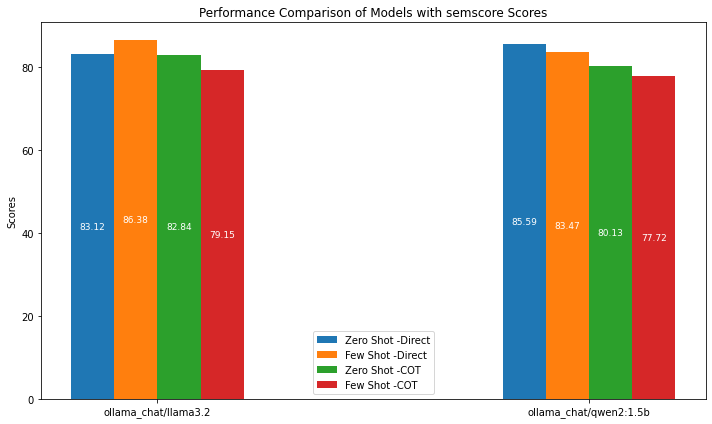

In [23]:
import matplotlib.pyplot as plt
df = pd.DataFrame(results_semscore)

# Plot with scores centered on bars
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df['Model']))

# Bar widths and positions
width = 0.1

# Plot each metric
bars1 = ax.bar(x, df['Zero Shot -Direct'], width=width, label='Zero Shot -Direct', align='center')
bars2 = ax.bar([i + width for i in x], df['Few Shot -Direct'], width=width, label='Few Shot -Direct', align='center')
bars3 = ax.bar([i + 2 * width for i in x], df['Zero Shot -COT'], width=width, label='Zero Shot -COT', align='center')
bars4 = ax.bar([i + 3 * width for i in x], df['Few Shot -COT'], width=width, label='Few Shot -COT', align='center')

# Add individual scores at the center of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.2f}',
                ha='center', va='center', fontsize=9, color='white')

# Customize plot
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(df['Model'])
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models with semscore Scores')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

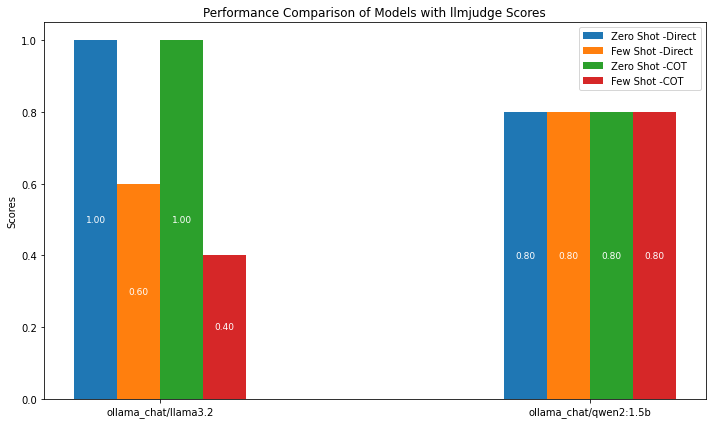

In [24]:
df = pd.DataFrame(results_llmjudge)

# Plot with scores centered on bars
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df['Model']))

# Bar widths and positions
width = 0.1

# Plot each metric
bars1 = ax.bar(x, df['Zero Shot -Direct'], width=width, label='Zero Shot -Direct', align='center')
bars2 = ax.bar([i + width for i in x], df['Few Shot -Direct'], width=width, label='Few Shot -Direct', align='center')
bars3 = ax.bar([i + 2 * width for i in x], df['Zero Shot -COT'], width=width, label='Zero Shot -COT', align='center')
bars4 = ax.bar([i + 3 * width for i in x], df['Few Shot -COT'], width=width, label='Few Shot -COT', align='center')

# Add individual scores at the center of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.2f}',
                ha='center', va='center', fontsize=9, color='white')

# Customize plot
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(df['Model'])
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models with llmjudge Scores')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()